<font size="5">Customer Segmentation & Profiling</font>

<br />

**In progress**

In this project, customer clusters are analyzed in order to profile the characteristics of each cluster, with the ultimate goals of understanding how each cluster relates to key metrics like spending score and predicting the cluster of new leads.

<br />

<u>Business Challenge<u/>
    
An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5).\
After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

In their existing market, the sales team had classified all customers into one of 4 segments (A, B, C, D) before conducting segmented outreach and communications.\
This strategy worked exceptionally well for them, however through a series of events all knowledge of these segments' characteristics was lost.

You are tasked with:
- Predicting customer labels, while minimizing the cost and resources needed for inference in your company's cloud platform
- Creating a profile of each cluster's characteristics to assist key stakeholders in better understanding customer types

<br />

<u>Data Notes<u/>
- Dataset contains 8068 customer records labelled for training, and 2627 test records
  - Data features consist of 10 customer attributes (numeric or categorical) of differing ranges
  - Data labels contain the provided/true cluster for each instance
  - Source (data + scenario): https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data

In [1]:
#Imports
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import seaborn.objects as so
import numpy as np

 #Configure pandas for high dimensionality dataframes
pd.set_option('display.max_columns', None)

<h4 align="center"> Section 1: Data Exploration & Cluster Analysis Preprocessing </h4>

In [2]:
#Load data + review attributes
df_train = pd.read_csv(r'C:\Users\Public\cust_train.csv')
#df_test = pd.read_csv(r'C:\Users\Public\cust_test.csv')
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None


In [3]:
#Preview data
df_train.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [4]:
#Remove ID column
cust_train = df_train.drop(df_train[['ID']], axis=1)

In [5]:
#Check label balance
cust_train['Segmentation'].value_counts(normalize=True)

Segmentation
D    0.281111
A    0.244422
C    0.244175
B    0.230293
Name: proportion, dtype: float64

In [6]:
#Count missing values
cust_train.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
#Drop records with missing values
cust_train = cust_train.dropna()
 #Reset index
cust_train.reset_index(drop=True, inplace=True)
#Convert float cols to int
cust_train = cust_train.astype({'Work_Experience':int, 'Family_Size':int})
print("Records after dropping missing values: "+str(len(cust_train)))
cust_train.head(3)

Records after dropping missing values: 6665


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1,Low,4,Cat_4,D
1,Female,Yes,67,Yes,Engineer,1,Low,1,Cat_6,B
2,Male,Yes,67,Yes,Lawyer,0,High,2,Cat_6,B


We'll examine our categorical attributes, including category frequencies

In [8]:
#Explore categorical columns
obj_tr = (cust_train.dtypes == 'object')
obj_cols_tr = list(obj_tr[obj_tr].index)
obj_cols_tr

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1',
 'Segmentation']

In [9]:
 #List categories and levels
cat_count=0
for col in obj_cols_tr:
    print(pd.DataFrame(cust_train[col].value_counts()))
    cat_count += len(cust_train[col].value_counts())
print('\nTotal # categorical levels/values: ', cat_count)

        count
Gender       
Male     3677
Female   2988
              count
Ever_Married       
Yes            3944
No             2721
           count
Graduated       
Yes         4249
No          2416
               count
Profession          
Artist          2192
Healthcare      1077
Entertainment    809
Doctor           592
Engineer         582
Executive        505
Lawyer           500
Marketing        233
Homemaker        175
                count
Spending_Score       
Low              3999
Average          1662
High             1004
       count
Var_1       
Cat_6   4476
Cat_4    849
Cat_3    634
Cat_2    362
Cat_7    166
Cat_1    104
Cat_5     74
              count
Segmentation       
D              1757
C              1720
A              1616
B              1572

Total # categorical levels/values:  29


<br/>

There are a surprising number of Artists;\
we can plot categories pairwise for more detailed depictions of the customer base.

In [10]:
int_df = cust_train.copy()
 #Readability
int_df.rename(columns={'Ever_Married':'Ever Married','Work_Experience':'Work Experience','Spending_Score':'Spending Score','Family_Size':'Family Size','Segmentation':'Segment'}, inplace=True)
print(int_df.shape)

(6665, 10)


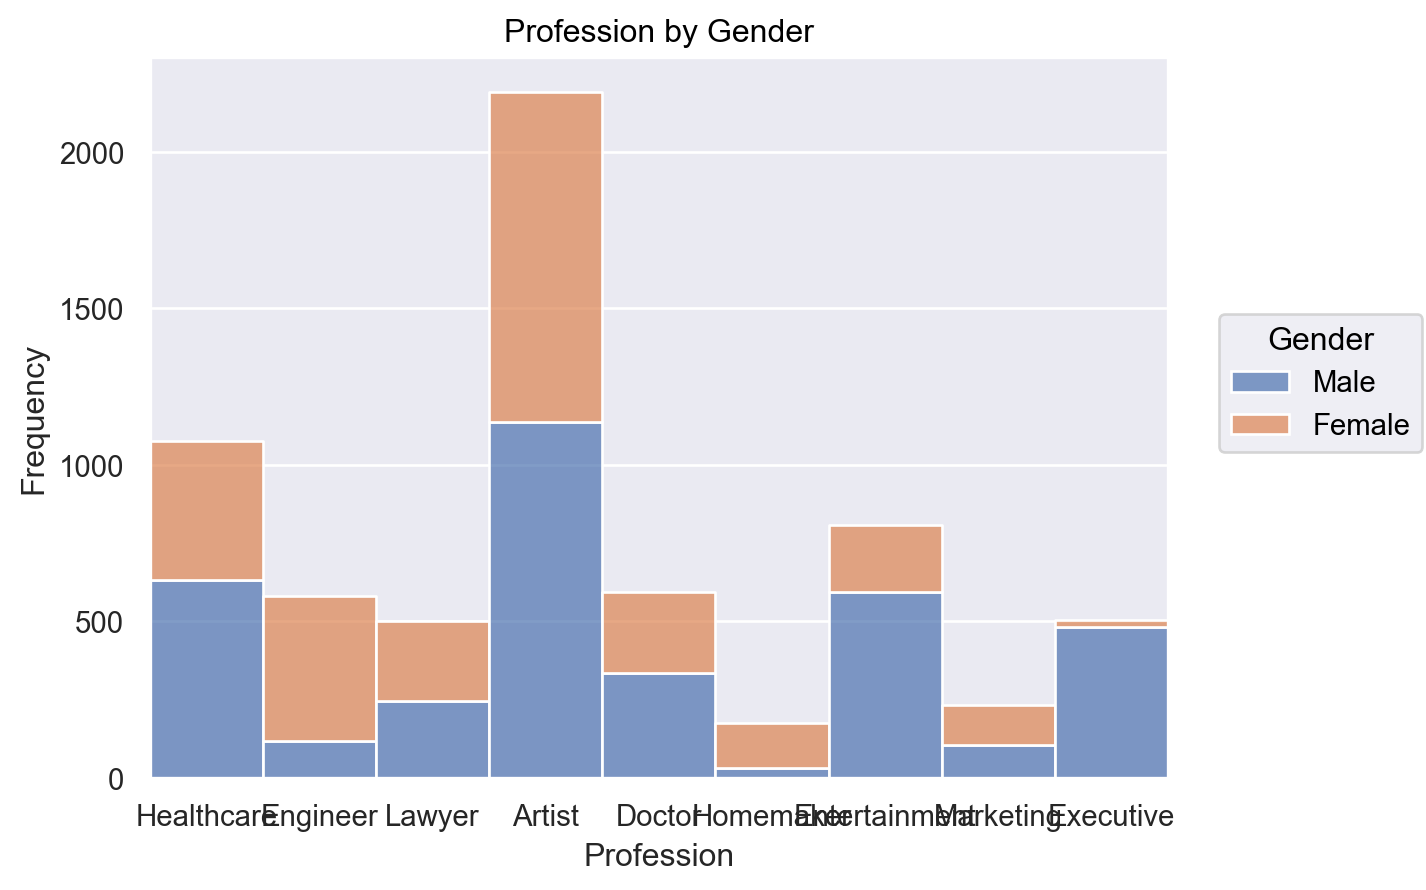

In [11]:
#Profession by Gender
plt_ProfGen = (
    so.Plot(int_df, x='Profession', color='Gender')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plt_ProfGen.label(y='Frequency', title='Profession by Gender')

Some professions appear to have a degree of gender balance, however customers with Engineering and Homemaking occupations are mostly Female, while customers employed in Entertainment or as Executives are mostly male.

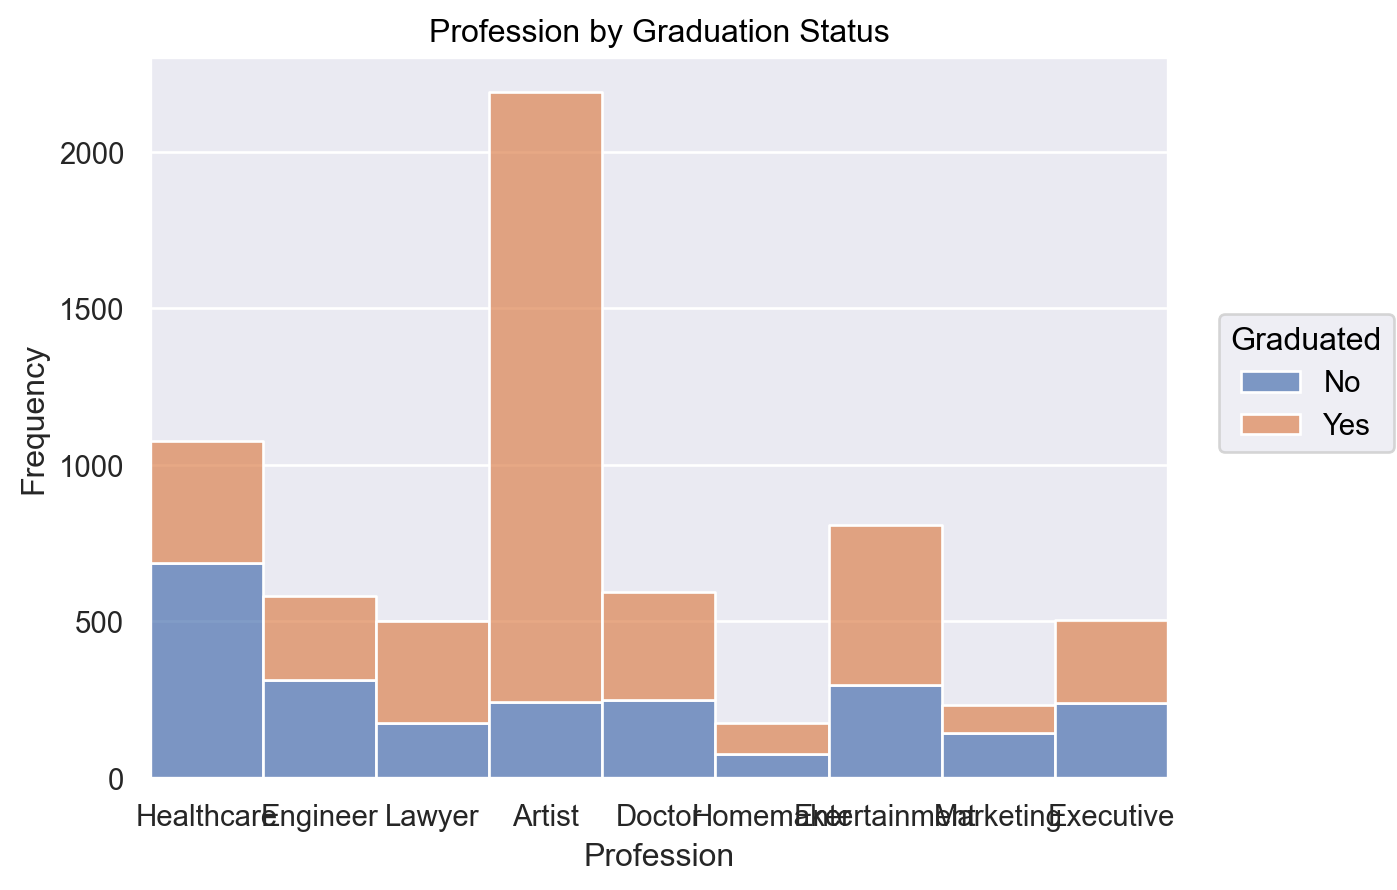

In [12]:
#Profession by Graduated
plt_ProfGrad = (
    so.Plot(int_df, x='Profession', color='Graduated')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plt_ProfGrad.label(y='Frequency', title='Profession by Graduation Status')

There is an unsettling proportion of Doctors (among other occupations) who didn't graduate,\
and a surprising number of graduates who are Artists.

We'll chalk these perplexing observations up as artefacts of a synthetic dataset and continue.

<h4 align="center"> Section 2: Cluster Analysis </h4>

Now we'll analyze the characteristics of the clusters the sales team created using these interpretable features.

In [13]:
clusterA = int_df[int_df['Segment']=='A']
clusterB = int_df[int_df['Segment']=='B']
clusterC = int_df[int_df['Segment']=='C']
clusterD = int_df[int_df['Segment']=='D']

print(clusterA.shape, clusterB.shape, clusterC.shape, clusterD.shape)
clusterA.head(2)

(1616, 10) (1572, 10) (1720, 10) (1757, 10)


,Gender,Ever Married,Age,Graduated,Profession,Work Experience,Spending Score,Family Size,Var_1,Segment
8,Female,No,26,Yes,Engineer,1,Low,3,Cat_6,A
16,Male,Yes,49,Yes,Homemaker,12,Low,1,Cat_3,A


Using more nuanced visualizations, we can explore the customer base in even finer detail;\
Let's look at the distribution of each numeric feature, by spending level and cluster:

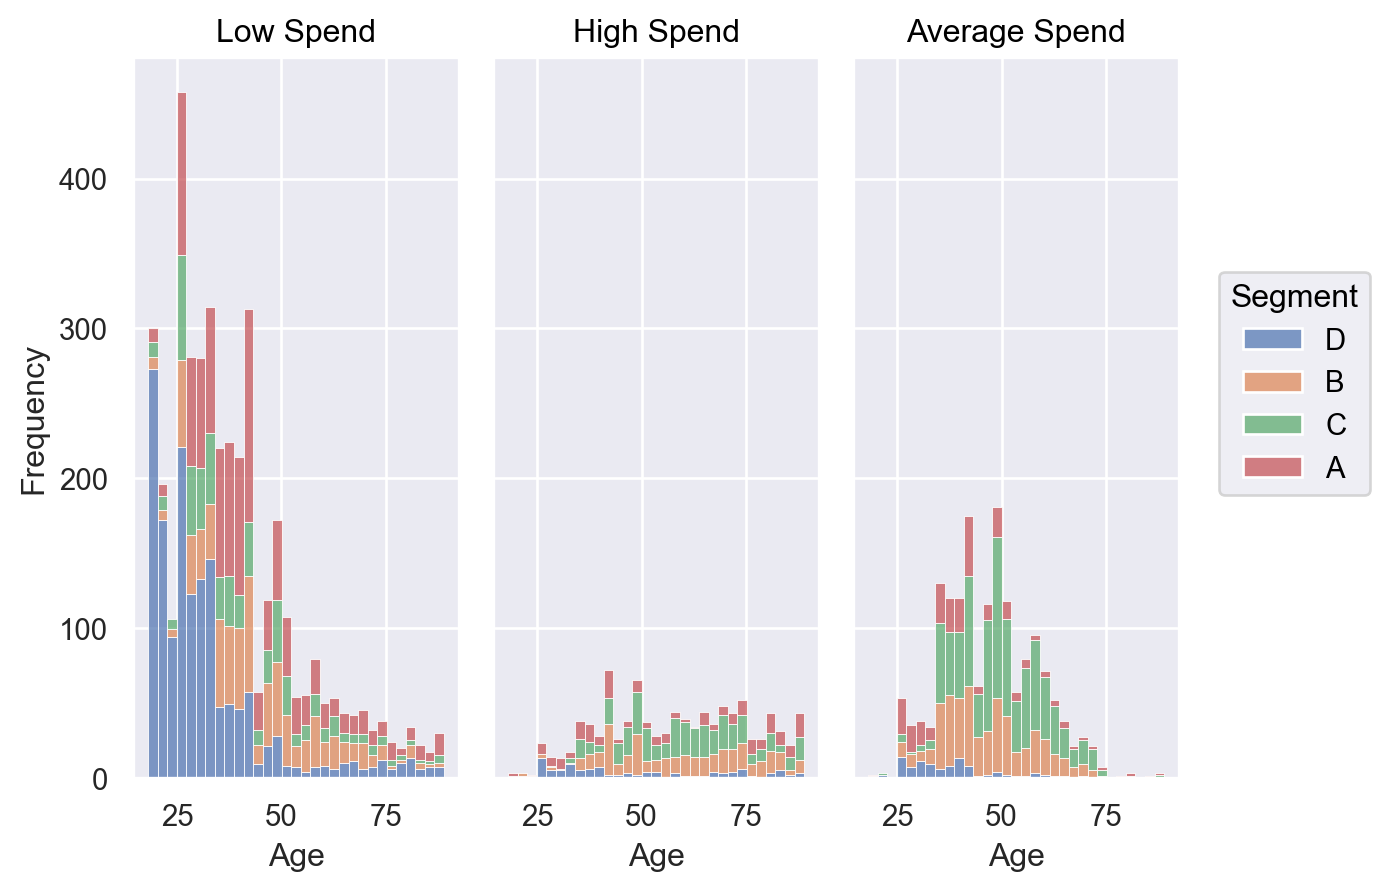

In [14]:
plot_age = (
    so.Plot(int_df, x='Age', color='Segment')
    .facet('Spending Score')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plot_age.label(y='Frequency', title='{} Spend'.format)

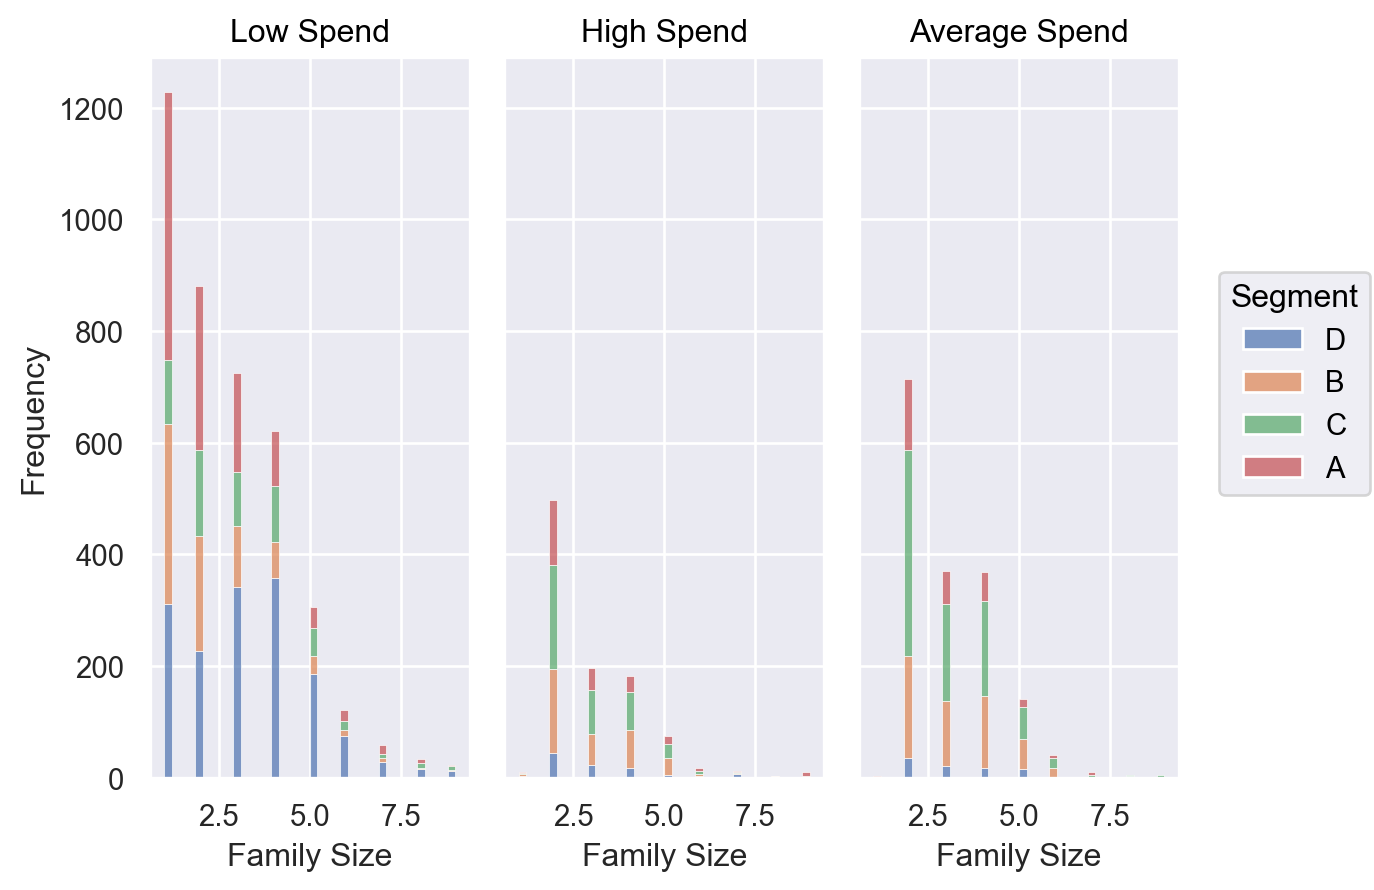

In [15]:
plot_fam = (
    so.Plot(int_df, x='Family Size', color='Segment')
    .facet('Spending Score')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plot_fam.label(y='Frequency', title='{} Spend'.format)

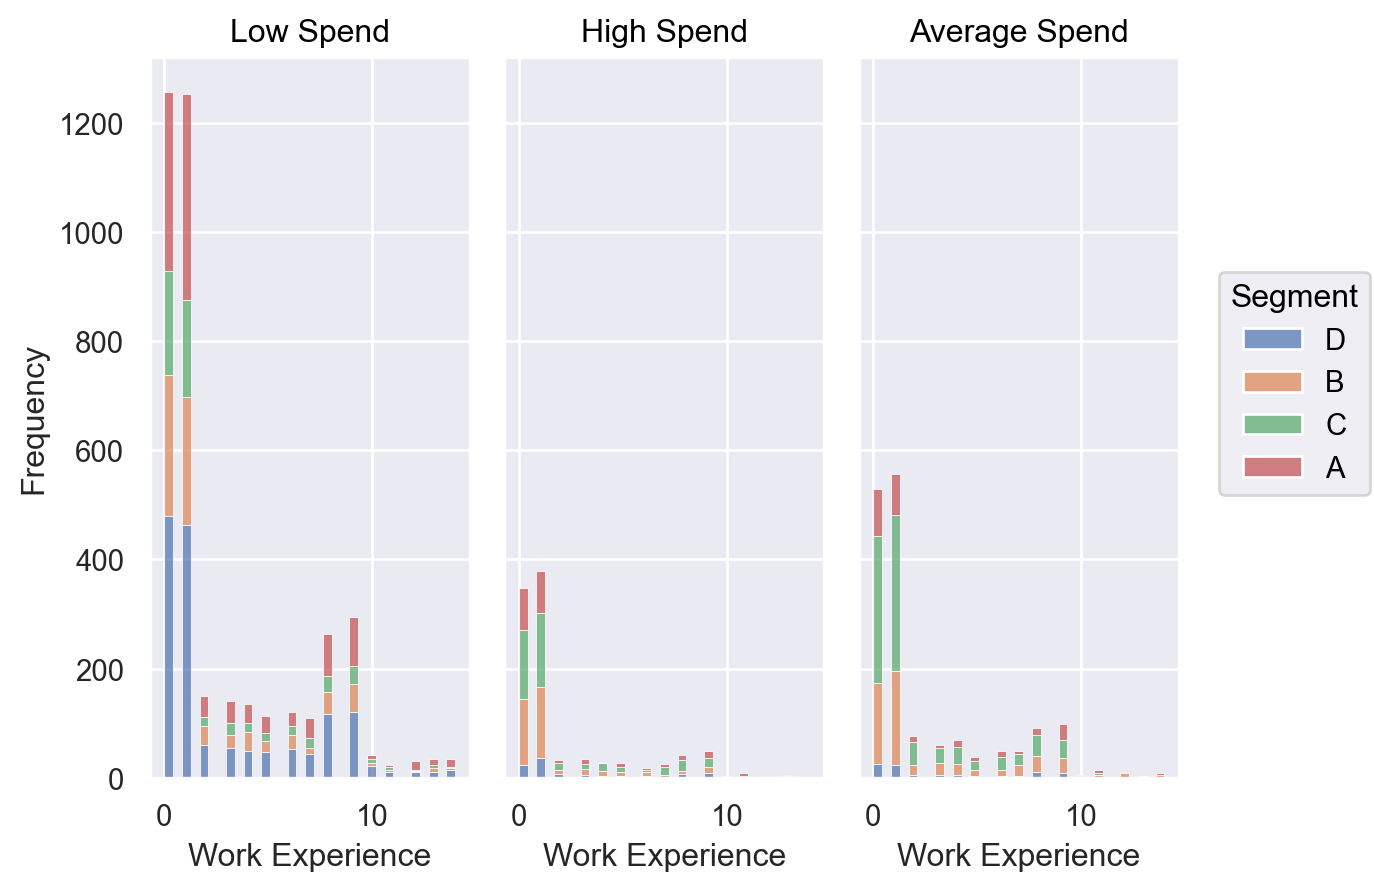

In [16]:
plot_exp = (
    so.Plot(int_df, x='Work Experience', color='Segment')
    .facet('Spending Score')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plot_exp.label(y='Frequency', title='{} Spend'.format)

From a quick glance at these plots, we can observe:

<u>Cluster C<u/>
- Appears to be largely customers aged 25-75 years old
- Spans all levels of spend, but looks to be concentrated most at 'Average'
- Proportionally, and interestingly, few customers are above 2 years of work experience

<u>Cluster D<u/>
- Appears to be the youngest, being almost entirely under 50
- Predominantly in the 'Low Spend' category
- U-shaped, positive-skewed distribution of Work Experience years

The first visual suggests age-related differences between clusters; we can evaluate this possibility statistically:

In [17]:
int_df.groupby(['Segment']).describe()

Age                                                       \
          count       mean        std   min    25%   50%   75%   max   
Segment                                                                
A        1616.0  44.421411  16.173020  18.0  33.00  40.0  51.0  89.0   
B        1572.0  48.113232  14.693990  18.0  38.00  46.0  58.0  89.0   
C        1720.0  49.327907  14.479229  18.0  38.75  49.0  59.0  89.0   
D        1757.0  32.956744  15.261702  18.0  22.00  29.0  37.0  89.0   

        Work Experience                                                \
                  count      mean       std  min  25%  50%  75%   max   
Segment                                                                 
A                1616.0  2.888614  3.627206  0.0  0.0  1.0  5.0  14.0   
B                1572.0  2.393766  3.246823  0.0  0.0  1.0  4.0  14.0   
C                1720.0  2.224419  3.036655  0.0  0.0  1.0  3.0  14.0   
D                1757.0  2.997154  3.611468  0.0  0.0  1.0  6.0  14.0   

        Family Size                                               
              count      mean       std  min  25%  50%  75%  max  
Segment                                                           
A            1616.0  2.431931  1.479794  1.0  1.0  2.0  3.0  9.0  
B            1572.0  2.682570  1.411195  1.0  2.0  2.0  4.0  9.0  
C            1720.0  2.961628  1.374467  1.0  2.0  3.0  4.0  9.0  
D            1757.0  3.241320  1.681278  1.0  2.0  3.0  4.0  9.0

In [18]:
int_df.groupby(['Spending Score']).describe()

Age                                                      \
                 count       mean        std   min   25%   50%   75%   max   
Spending Score                                                               
Average         1662.0  46.921179  11.208190  20.0  39.0  47.0  55.0  89.0   
High            1004.0  58.294821  17.347505  18.0  45.0  58.0  72.0  89.0   
Low             3999.0  38.423856  15.550741  18.0  27.0  35.0  46.0  89.0   

               Work Experience                                                \
                         count      mean       std  min  25%  50%  75%   max   
Spending Score                                                                 
Average                 1662.0  2.483755  3.231865  0.0  0.0  1.0  4.0  14.0   
High                    1004.0  2.104582  3.000834  0.0  0.0  1.0  2.0  14.0   
Low                     3999.0  2.821205  3.551915  0.0  0.0  1.0  5.0  14.0   

               Family Size                                               
                     count      mean       std  min  25%  50%  75%  max  
Spending Score                                                           
Average             1662.0  3.092058  1.227547  1.0  2.0  3.0  4.0  9.0  
High                1004.0  2.992032  1.347771  1.0  2.0  2.0  4.0  9.0  
Low                 3999.0  2.698925  1.655671  1.0  1.0  2.0  4.0  9.0

These parameters describe the numeric feature distributions when grouped by segment or spend category;\
indeed, 50% of cluster D customers are between 22 and 37 years old, compared to 50% between 33-51 in cluster A,\
and between ~38-59 in clusters B and C.

Let's use a different visualization to focus on family sizes between clusters.

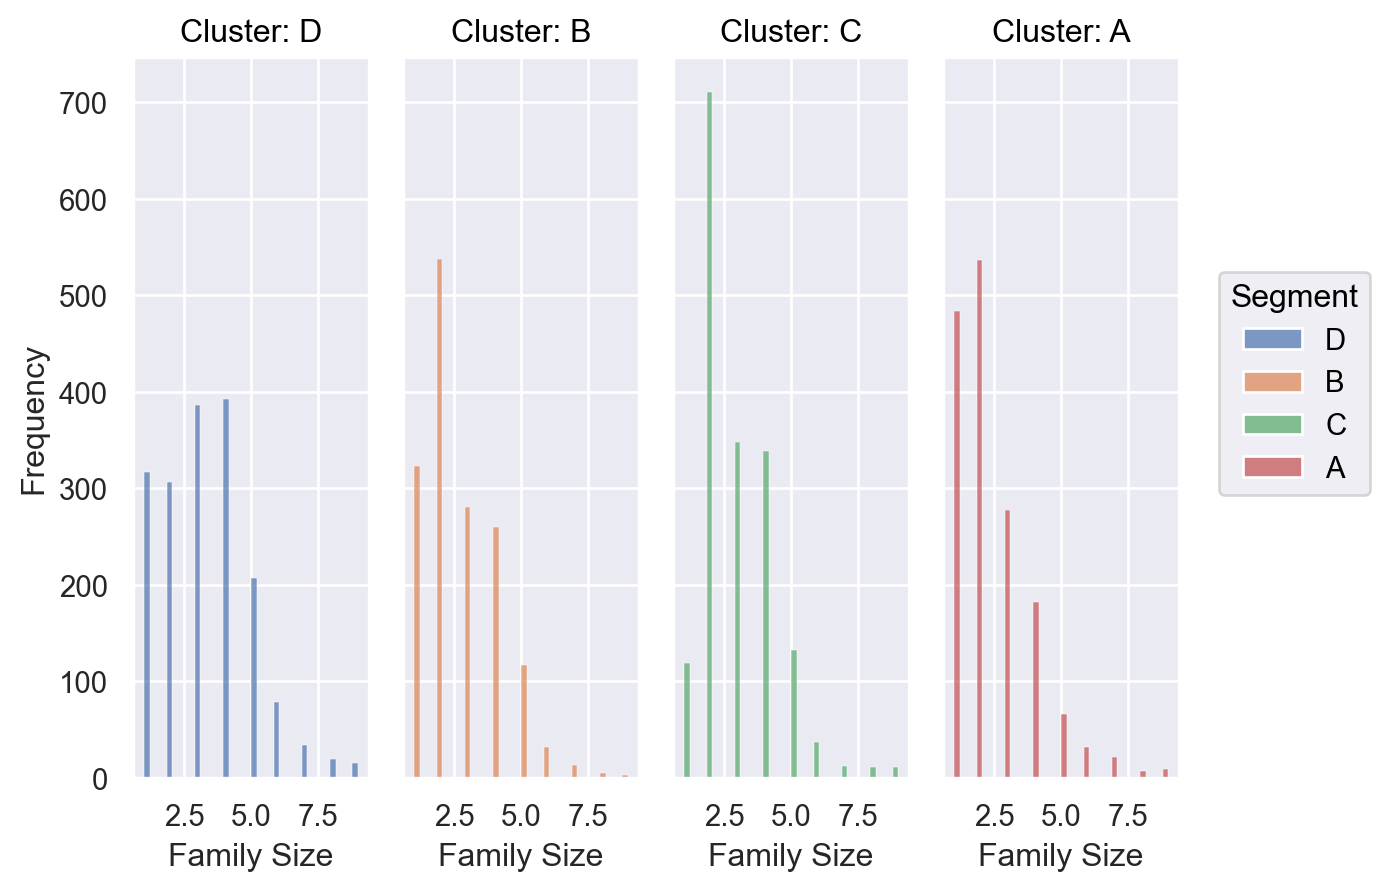

In [19]:
plot_clust_fam = (
    so.Plot(int_df, x='Family Size', color='Segment')
    .facet('Segment')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plot_clust_fam.label(x='Family Size', y='Frequency', col='Cluster:')

<u>Cluster C<u/>
- Immediately stands out with just over 700 customers having a family size of 2
  - This might be a discerning characteristic, but clusters A and B also appear to have a high proportion of 2 person families

<u>Cluster D<u/>
- Appears to have the most families of 6 or more

Let's evaluate the proportions.

In [20]:
clusters = [clusterA, clusterB, clusterC, clusterD]

df_clust_fam = pd.concat([pd.DataFrame(cluster['Family Size'].value_counts(normalize=True)) for cluster in clusters], axis=1)
df_clust_fam.columns = ['A', 'B', 'C', 'D']                        

df_clust_fam

,A,B,C,D
Family Size,,,,
2,0.332302,0.342239,0.413372,0.174730
1,0.299505,0.205471,0.069186,0.180421
3,0.171411,0.178753,0.202326,0.219693
4,0.112624,0.165394,0.197093,0.223677
5,0.040842,0.074427,0.076744,0.117814
6,0.019802,0.020356,0.021512,0.044963
7,0.013614,0.008270,0.006977,0.019351
9,0.005569,0.001908,0.006395,0.008537
8,0.004332,0.003181,0.006395,0.010814


Cluster D has more than double the proportion of 6+ person families relative to other clusters.

Cluster C is indeed 41% made up of 2-person families, the highest of any cluster by about 7%.
- Taken together with being the oldest cluster, at a median age of 49 and only 25% (n=430) below ~39 years, we might interpret this grouping as being largely comprised of middle-to-older aged customers living with one other person (e.g., couples, carers, and single-child, single-parent families)

<h4 align="center"> Section 3: Data Transformations, EDA, & Outlier Removal </h4>

Next we'll encode our labels and categorical features for use in the Logistic Regression algorithm.\
This also allows us to evaluate correlations for all attributes.

In [21]:
#Feature df for memory comparison
feats_df = cust_train.drop(cust_train[['Segmentation']], axis=1)

In [22]:
#Encode categorical variables depending on relationships between values
 #LabelEncoder for label ('Segmentation'); maps labels alphabetically (A=0, D=3)
enc_lab = LabelEncoder()
 #OrdinalEncoder for 'Spending_Score'; assign Spend_Score categories to continuous values (Low=1, high=3)
enc_ord = OrdinalEncoder(categories=[['skip','Low','Average','High']])
 #OneHotEncoder for remaining categorical features
enc_OneH = OneHotEncoder(sparse_output=False, dtype=int)

In [23]:
cust_enc = cust_train.copy()

 #Encode labels
cust_enc['Segmentation'] = enc_lab.fit_transform(cust_enc['Segmentation'])
 #Encode 'Spending_Score'
cust_enc['Spending_Score'] = enc_ord.fit_transform(cust_enc[['Spending_Score']]).astype(int)

cust_enc.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1,1,4,Cat_4,3
1,Female,Yes,67,Yes,Engineer,1,1,1,Cat_6,1
2,Male,Yes,67,Yes,Lawyer,0,3,2,Cat_6,1


In [24]:
#Remaining categorical vars (not label or ordinal)
cols_rem = [col for col in obj_cols_tr if col not in ['Spending_Score', 'Segmentation']]
cols_rem

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']

In [25]:
#Encode features in dataframe
cats_enc = pd.DataFrame(enc_OneH.fit_transform(cust_enc[cols_rem]), columns=enc_OneH.get_feature_names_out())
 #Preview One-Hot features
print(cats_enc.shape)
cats_enc.head(3)

(6665, 22)


,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [26]:
#Combine original and one hot feature dataframes
cust_enc = pd.concat([cust_enc, cats_enc], axis=1)
 #Drop pre-transformation features
cust_enc = cust_enc.drop(cust_enc[['Gender','Ever_Married','Graduated','Profession','Var_1']], axis=1)
 #Move Label to last column
cust_enc['Segmentation'] = cust_enc.pop('Segmentation')
 #Preview full pre-processed df
cust_enc.head(3)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,22,1,1,4,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3
1,67,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,67,0,3,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [27]:
#Review summary statistics
cust_enc.describe()

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
count,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000
mean,43.536084,2.629107,1.550638,2.841110,0.448312,0.551688,0.408252,0.591748,0.362491,0.637509,0.328882,0.088822,0.087322,0.121380,0.075769,0.161590,0.026257,0.075019,0.034959,0.015604,0.054314,0.095124,0.127382,0.011103,0.671568,0.024906,1.542836
std,16.524054,3.405365,0.740806,1.524743,0.497358,0.497358,0.491547,0.491547,0.480755,0.480755,0.469842,0.284508,0.282327,0.326593,0.264648,0.368102,0.159909,0.263441,0.183689,0.123946,0.226652,0.293408,0.333425,0.104791,0.469678,0.155851,1.122723
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,41.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,53.000000,4.000000,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
max,89.000000,14.000000,3.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


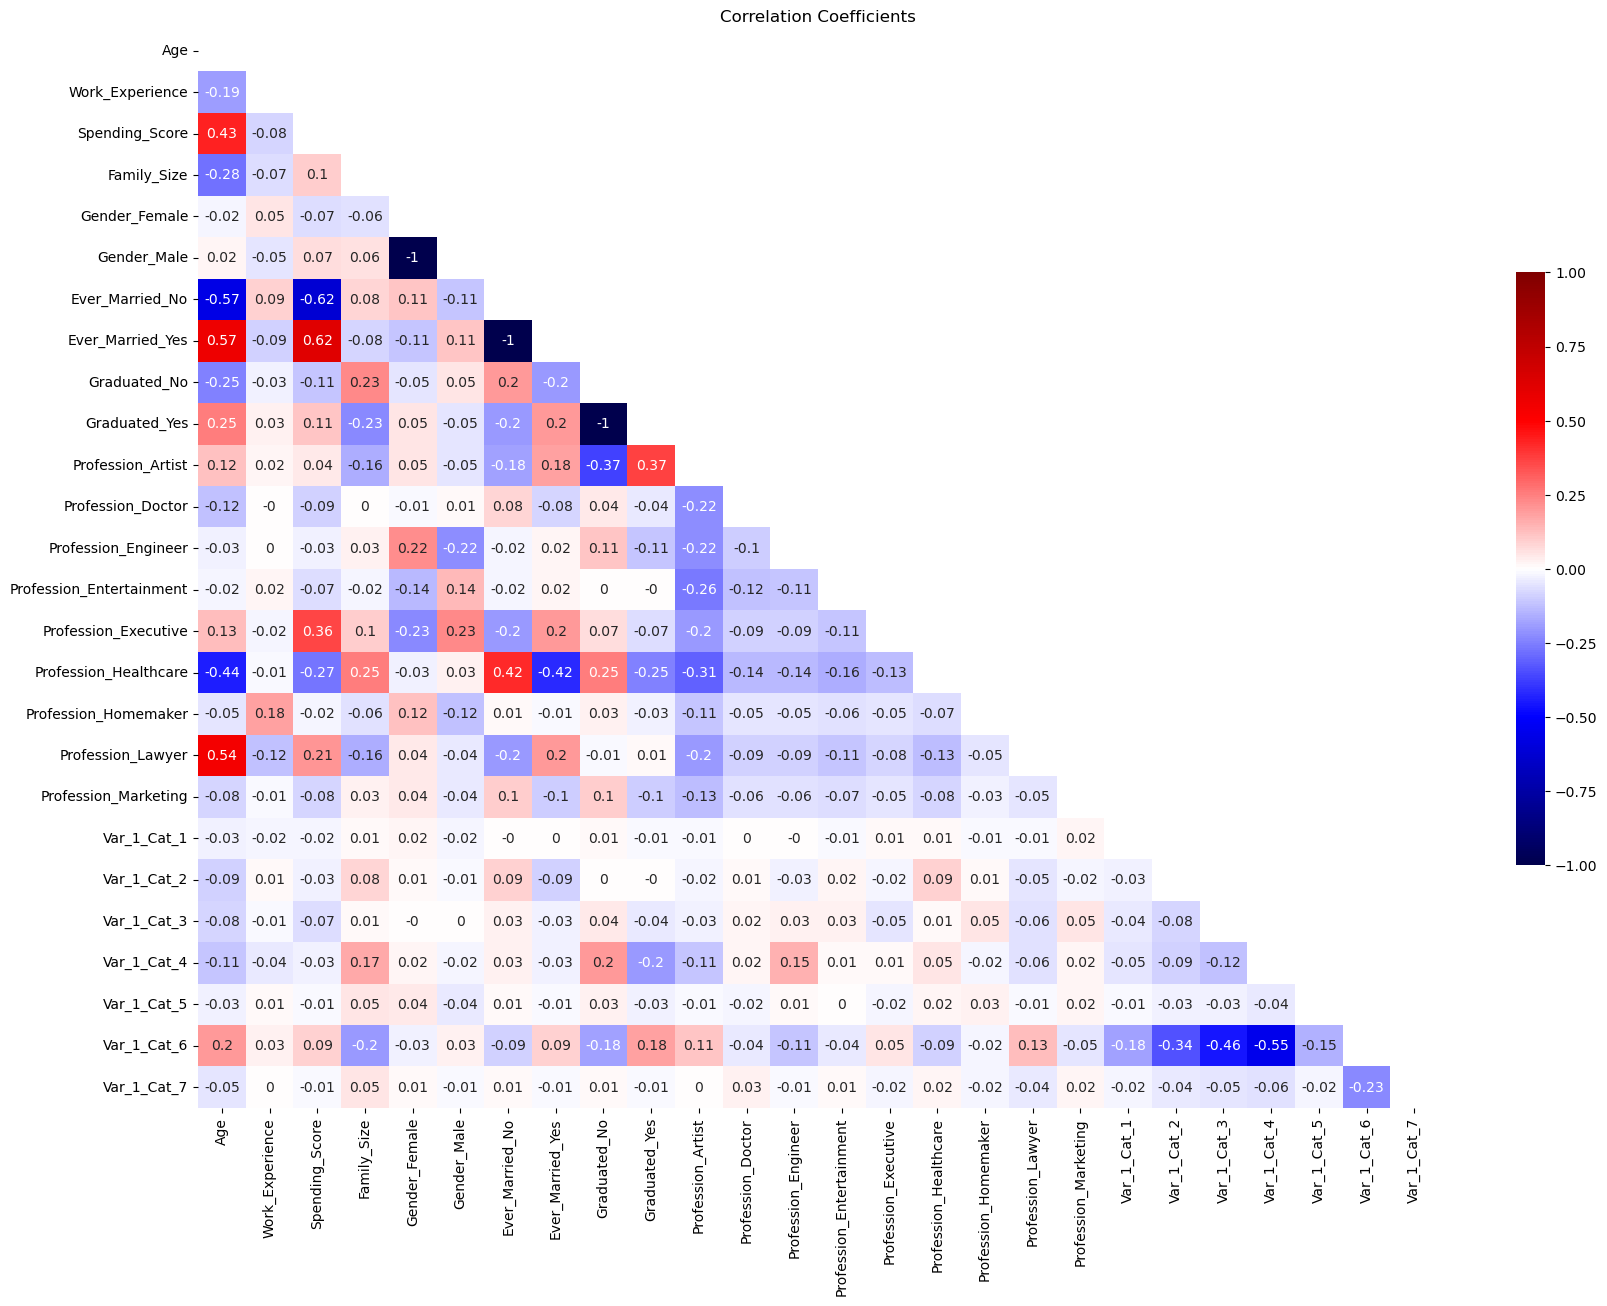

In [28]:
#Create correlation matrix

corr_df = cust_enc.copy()
corr_df = corr_df.drop(corr_df[['Segmentation']], axis=1)
corr_matrix = corr_df.corr().round(2)

mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(20,14))

sns.heatmap(corr_matrix, annot=True, cmap='seismic', mask=mask, vmin=-1, vmax=1, cbar_kws={'shrink': 0.55})
plt.title('Correlation Coefficients')
plt.show()

We can observe some simple associations in the correlation coefficients:
- Married people, lawyers, people who have graduated, and (to some degree) people in the anonymized Var_1 category '6' are correlated with greater ages
  - Healthcare workers tend to be younger
- Married people, lawyers, and exectives correlate with higher spending scores
  - Unmarried people and healthcare workers tend to spend less

Let's evaluate the distributions of our continous numeric features.

While normally distributed features aren't necessary for Logistic Regression, this provides more information and helps decide whether we'll remove detected outliers.

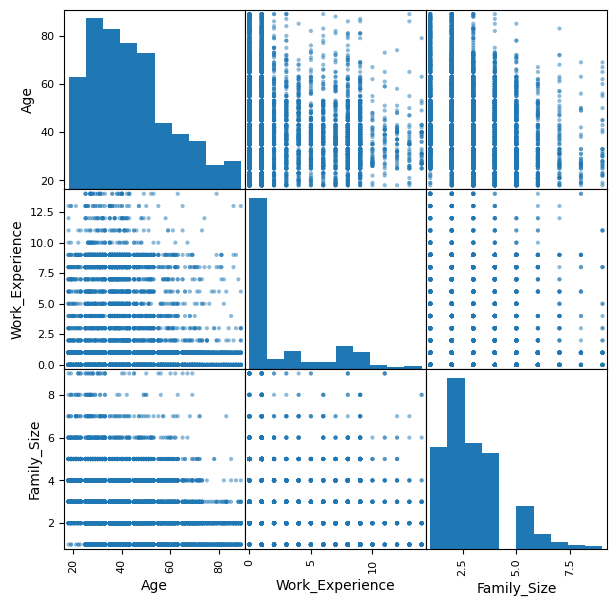

In [29]:
pd.plotting.scatter_matrix(cust_train, grid=True, figsize=(7,7))
plt.show()

The normality of these feature distributions appears questionable; let's evaluate them statistically, relative to the Standard Normal distribution.

In [30]:
#Skew analysis using moment-based formula
pd.DataFrame(stats.skew(cust_train[['Age','Work_Experience','Family_Size']], axis=0)).rename(index={0:'Age', 1:'Work Exp', 2:'Family Size'}, columns={0: 'Skew'})

,Skew
Age,0.684706
Work Exp,1.324062
Family Size,1.025655


In [31]:
#Pearson Kurtosis
pd.DataFrame(stats.kurtosis(cust_train[['Age','Work_Experience','Family_Size']], fisher=False)).rename(index={0:'Age', 1:'Work Exp', 2:'Family Size'}, columns={0: 'Kurtosis'})

,Kurtosis
Age,2.858635
Work Exp,3.582960
Family Size,4.314236


In evaluating Skewness and Kurtosis statistics, we'll use moderate acceptability ranges of 0 (+/-)2 for Skewness, and 3 (+/-)2 for Kurtosis.

<u>Skewness<u/>
- While skew values above 1 indicate highly right-skewed distributions for Work Experience and Family Size, they're within the acceptable range

<u>Kurtosis<u/>
- Kurtosis of less than 3 for Age indicates that its distribution is flatter than normal, with a wide peak, smaller tails, and a lower likelihood of outliers;\
it is still within the acceptable range
- Kurtosis above 3 for Work Experience and Family Size indicates these distributions are highly peaked, with values closer around the mean and an increased likelihood that observations away from the mean will be considered outliers;\
The kurtosis of Family Size is particularly high, but still inside the acceptable range

<br/>
It's useful to know that our continuous features are skewed, with less or more of a peak compared to the normal distribution, but reasonably approximate normality.

We'll continue with outlier removal.
First we'll scale the data to reduce the undue influence of features with different magnitudes and speed convergence in our Logistic Regression
- This step is also important for Principle Component Analysis later on
- We'll detect and remove any outliers using these standardized values

In [32]:
#Store + drop unscaled labels
cust_tr_seg = cust_enc['Segmentation']
cust_tr = cust_enc.drop(cust_train[['Segmentation']], axis=1)

In [33]:
#Save column names
col_names = pd.Series(cust_tr.columns)

#Scale data + reapply column titles
scaler = StandardScaler()
cust_tr_sc = pd.DataFrame(scaler.fit_transform(cust_tr))
cust_tr_sc.rename(columns=col_names, inplace=True)

In [34]:
#Concat unscaled labels
cust_tr_sc = pd.concat([cust_tr_sc, cust_tr_seg], axis=1)
cust_tr_sc.head(3)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,-1.303415,-0.478430,-0.743351,0.760113,-0.901454,0.901454,1.203938,-1.203938,1.326157,-1.326157,-0.700037,-0.312219,-0.309316,-0.371684,-0.286322,2.277825,-0.164209,-0.284786,-0.190329,-0.125902,-0.239652,-0.324228,2.617329,-0.10596,-1.429954,-0.15982,3
1,1.420092,-0.478430,-0.743351,-1.207580,1.109319,-1.109319,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,3.232938,-0.371684,-0.286322,-0.439015,-0.164209,-0.284786,-0.190329,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,1
2,1.420092,-0.772106,1.956614,-0.551682,-0.901454,0.901454,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,-0.309316,-0.371684,-0.286322,-0.439015,-0.164209,3.511410,-0.190329,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,1


In [35]:
#Continuous feature descriptive statistics
df_num = cust_tr_sc[['Age', 'Work_Experience', 'Family_Size']]
df_num.describe()

,Age,Work_Experience,Family_Size
count,6.665000e+03,6.665000e+03,6.665000e+03
mean,-1.385905e-17,-1.385905e-17,8.528645e-18
std,1.000075e+00,1.000075e+00,1.000075e+00
min,-1.545505e+00,-7.721065e-01,-1.207580e+00
25%,-7.587136e-01,-7.721065e-01,-5.516822e-01
50%,-1.534898e-01,-4.784302e-01,-5.516822e-01
75%,5.727787e-01,4.025987e-01,7.601129e-01
max,2.751584e+00,3.339362e+00,4.039601e+00


We can already see that there are some values past 3 standard deviations at the max of Work Experience and Family Size.

In [36]:
#Select features of interest
num_var = pd.DataFrame(cust_tr_sc[['Age','Work_Experience','Family_Size']])
 #Set outlier z-score threshold
stdDev_lim = 3

#Df of boolean comparisons for scaled values past limit in either direction
outlier_bool = (np.abs(num_var) > stdDev_lim)

In [37]:
#df of T/F for outlier value across all 3 features
outlier_T_F = outlier_bool.any(axis=1)
print(outlier_T_F.head(2))
 #total outliers
print('\nTotal outlier record count (\'True\'):')
print(outlier_T_F.value_counts())
 #detailed outlier value breakdown
print('\nDetailed outlier record count:')
outlier_bool.value_counts()

0    False
1    False
dtype: bool

Total outlier record count ('True'):
False    6501
True      164
Name: count, dtype: int64

Detailed outlier record count:


Age    Work_Experience  Family_Size
False  False            False          6501
       True             False            84
       False            True             78
       True             True              2
Name: count, dtype: int64

In [38]:
outlier_inds = np.where(outlier_T_F == True)[0][:]

#Preview detection df
outlier_records = cust_enc.loc[outlier_inds]
outlier_bool.loc[outlier_inds].head(5)

,Age,Work_Experience,Family_Size
18,False,True,False
21,False,False,True
35,False,True,False
45,False,True,False
127,False,False,True


In [39]:
#Lets see what these outlier records actually look like:
outlier_records.head(5)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
18,33,13,1,2,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
21,31,9,1,8,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
35,27,14,1,3,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
45,32,14,2,2,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
127,67,0,3,9,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [40]:
#Drop outliers
cust_tr_sc = cust_tr_sc.drop(outlier_inds)
cust_tr_sc.reset_index(drop=True, inplace=True)
print(cust_tr_sc.shape)
print('Removed an additional',6665-len(cust_tr_sc),'records containing outlier feature values')

(6501, 27)
Removed an additional 164 records containing outlier feature values


In [41]:
#Updated balance
cust_tr_sc['Segmentation'].value_counts(normalize=True)

Segmentation
3    0.260883
2    0.259652
0    0.241809
1    0.237656
Name: proportion, dtype: float64

In [42]:
#Updated continuous feature descriptive statistics
df_num2 = cust_tr_sc[['Age', 'Work_Experience', 'Family_Size']]
df_num2.describe()

,Age,Work_Experience,Family_Size
count,6501.000000,6501.000000,6501.000000
mean,0.012930,-0.042094,-0.039253
std,1.001101,0.936667,0.918147
min,-1.545505,-0.772106,-1.207580
25%,-0.758714,-0.772106,-0.551682
50%,-0.153490,-0.478430,-0.551682
75%,0.572779,0.402599,0.760113
max,2.751584,2.752009,2.727806


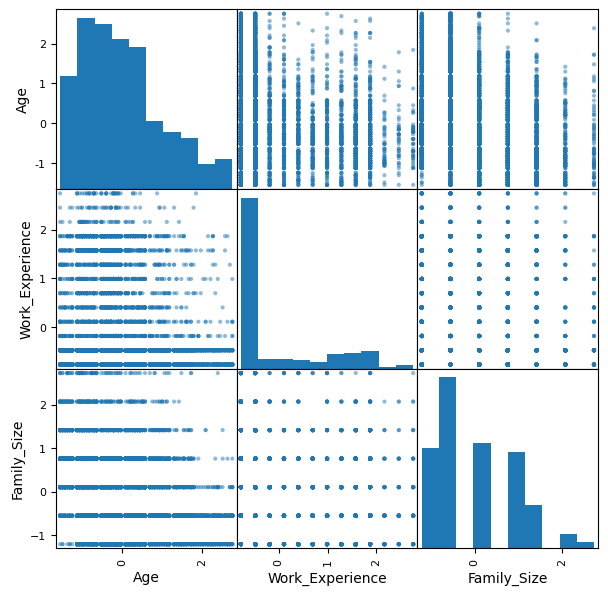

In [43]:
#Continuous feature distributions after outlier removal
pd.plotting.scatter_matrix(df_num2, grid=True, figsize=(7,7))
plt.show()

<h4 align="center"> Section 4: Dimensionality Reduction & Prediction </h4>

Let's try a Logistic Regression (supervised learning) using the scaled training features for a baseline measure of predictive accuracy.

Our selection of optimizer and loss function is guided by our dataset and evaluations of it so far:
- Our task is multiclass prediction, and we'd prefer predictions for all classes rather than one-vs-rest
- We're assuming that all features are meaningful, and we know many have a fair degree of correlation with another (especially our one-hot binary features)
- Our dataset is relatively small

Given these conditions, we'll use the default lbfgs optimizer with l2/Ridge loss, rather than l1 or elasticnet as an appropriate loss function.\
This decision is also supported by simple preliminary tests (without hyperparameter tuning).

In [44]:
#Split labelled train data into train (6/7) and test (1/7) sets
split_index = len(cust_tr_sc)//7

y_tr = cust_tr_sc.iloc[:-split_index, -1:]
y_tr = y_tr.to_numpy().reshape(len(y_tr),)

X_tr = cust_tr_sc.iloc[:-split_index, :-1]

y_te = cust_tr_sc.iloc[-split_index:, -1:]
y_te = y_te.to_numpy().reshape(len(y_te),)

X_te = cust_tr_sc.iloc[-split_index:, :-1]

In [45]:
X_tr.shape, y_tr.shape

((5573, 26), (5573,))

In [46]:
X_te.shape, y_te.shape

((928, 26), (928,))

In [47]:
#Fit + predict with LogReg model
base_log_reg = LogisticRegression(max_iter=2_500)

#Ridge (should be same)
#base_log_reg = LogisticRegression(max_iter=2_500, solver='saga', penalty='elasticnet', l1_ratio=0)
#Balanced
#base_log_reg = LogisticRegression(max_iter=2_500, solver='saga', penalty='elasticnet', l1_ratio=0.5)
#Lasso (feature selection)
#base_log_reg = LogisticRegression(max_iter=5_500, solver='saga', penalty='elasticnet', l1_ratio=1)

base_log_reg.fit(X_tr, y_tr)

base_score = base_log_reg.score(X_te, y_te)
print(base_score)

0.5280172413793104


<br/>
Now we'll use Principal Component Analysis (unsupervised learning) to project our features onto a lower dimensional subspace, reducing the dimensionality of our dataset from 26.

First let's determine how many principal components are required to retain 99 & 95% of the features' variance.

In [48]:
#Fit and output variance explained by each component in df
pca = PCA()
pca.fit(X_tr)

expl_var = pca.explained_variance_ratio_
ex_var_df = pd.DataFrame(expl_var)
ex_var_df.rename(columns={0:'Explained Variance'}, inplace=True)
print(ex_var_df.shape)
ex_var_df.transpose()

(26, 1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Explained Variance,0.154698,0.09612,0.080482,0.064225,0.05118,0.046984,0.045569,0.044394,0.043751,0.040858,0.039679,0.038638,0.038206,0.037275,0.036432,0.034771,0.030139,0.028562,0.021969,0.015107,0.010961,6.260185e-33,4.834996e-33,2.343387e-33,8.770279e-34,1.433844e-34


In [49]:
#Array of cumulative variance explained by principal components, sorted greatest to least
cumulative_sum = np.cumsum(expl_var)
cumulative_sum

array([0.15469777, 0.25081733, 0.33129919, 0.39552458, 0.44670427,
       0.49368837, 0.53925735, 0.58365091, 0.62740149, 0.66825934,
       0.70793873, 0.74657721, 0.78478353, 0.82205864, 0.85849097,
       0.89326199, 0.92340114, 0.95196349, 0.97393236, 0.98903901,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In these sorted views we see a few things:
- The first 3 components account for about 15.3/9.6/8% of information/variance
- The last 5 components are many orders of magnitude smaller, and add almost no information
  - The 3 components before these account for about 2.3/1.5/1.1% variance

Let's calculate the number of components necessary to preserve 95 and 99% of the total variance.

In [50]:
#Calculate + store '# components' for 95/99% of variance in variable
dim_95 = np.argmax(cumulative_sum >= 0.95) + 1
dim_99 = np.argmax(cumulative_sum >= 0.99) + 1

print(str(dim_95)+'\n'+str(dim_99))

18
21


In [51]:
#Store all components
p_comps = pca.transform(X_tr)
p_comps[0]

array([ 3.72456426e+00,  2.11695538e+00, -1.75447445e-01, -4.05151705e-01,
       -3.76571320e-01,  1.20241811e+00, -1.45168983e+00,  1.95734454e-02,
       -2.62837085e-01, -8.59381518e-01, -3.69408832e-01, -7.81504987e-01,
        9.50339344e-01, -3.19023072e-01,  1.02175574e+00, -6.33519823e-01,
       -2.68368621e-01,  1.35306624e-01, -3.52741961e-01, -2.31192641e-01,
       -3.48460865e-02,  2.85988129e-16,  7.28750557e-16,  1.94747380e-16,
        1.94253810e-16, -1.71358617e-15])

In [52]:
print(p_comps.shape)

(5573, 26)


In [53]:
#Create 95% and 99% variance sets
pc_95 = p_comps[:, :dim_95]
pc_99 = p_comps[:, :dim_99]
pc_95.shape, pc_99.shape

((5573, 18), (5573, 21))

Now let's use a more streamlined method, and create visualizations from our most informative principle components:

In [54]:
#Set desired variance retained at model instantiation
pca_99 = PCA(n_components=0.99)

In [55]:
#Create reduced/PCA-transformed datasets
X_tr_99 = pca_99.fit_transform(X_tr)

In [56]:
print(X_tr_99.shape)
X_tr_99[0]

(5573, 21)


array([ 3.72456426,  2.11695538, -0.17544744, -0.40515171, -0.37657132,
        1.20241811, -1.45168983,  0.01957345, -0.26283708, -0.85938152,
       -0.36940883, -0.78150499,  0.95033934, -0.31902307,  1.02175574,
       -0.63351982, -0.26836862,  0.13530662, -0.35274196, -0.23119264,
       -0.03484609])

In [57]:
X_tr_95 = X_tr_99[:, :dim_95]
X_tr_95.shape

(5573, 18)

In [58]:
#Plot first 3 PC of reduced dataset
x = X_tr_99[:, 0]
y = X_tr_99[:, 1]
z = X_tr_99[:, 2]

 #Value ranges
print(min(x), max(x))
print(min(y), max(y))
print(min(z), max(z))

-3.8701871510179835 4.420181836266024
-3.2530795364747265 4.7223888101759455
-2.7047913720824006 4.83394556728162


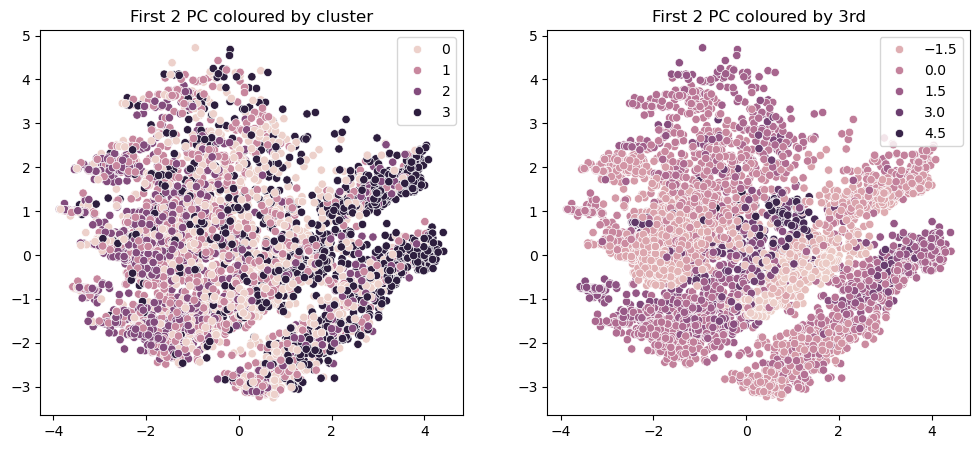

In [59]:
 #In 2 dimensions
fig, axes = plt.subplots(1, 2, figsize=(12,5))
  #First 2 principal components plotted in 2D, colored by cluster
sns.scatterplot(x=x, y=y, hue=y_tr, ax=axes[0])
axes[0].set_title('First 2 PC coloured by cluster')
  #First 2 principal components plotted in 2D, colored by 3rd PC
sns.scatterplot(x=x, y=y, hue=z, ax=axes[1])
axes[1].set_title('First 2 PC coloured by 3rd')
plt.show()

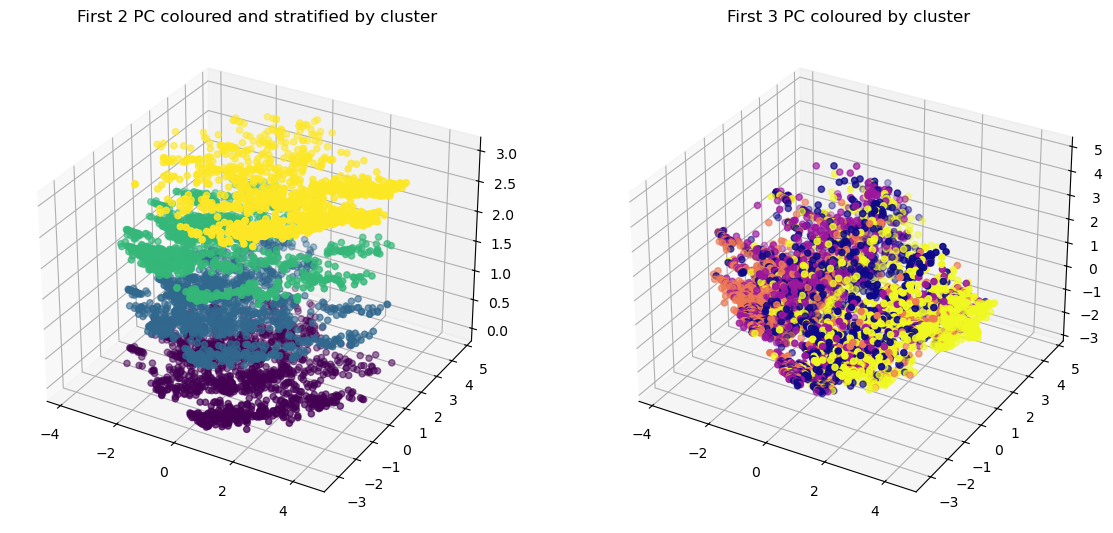

In [60]:
 #In 3 dimensions
  #First 2 principal components in 3D subspace, coloured and stratified vertically by cluster
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(14,12))
axes[0].scatter(x, y, y_tr, c=y_tr, marker="o")
axes[0].set_title("First 2 PC coloured and stratified by cluster")
  #First 3 principal components in 3D subspace, coloured by cluster
axes[1].scatter(x, y, z, c=y_tr, cmap='plasma', marker="o")
axes[1].set_title("First 3 PC coloured by cluster")
plt.show()

On the left we can visualize how when reduced to 2 principal components (explaining ~25% of variance), the instances in each layer seem to occupy somewhat characteristic regions but aren't very distinct, having much overlap.

On the right we can visualize how the first 3 principal components (explaining ~33% of variance) begin to show discernible groupings.

We can similarly visualize how the information from the first 2 principal components begins to contribute to the creation of decision boundaries:

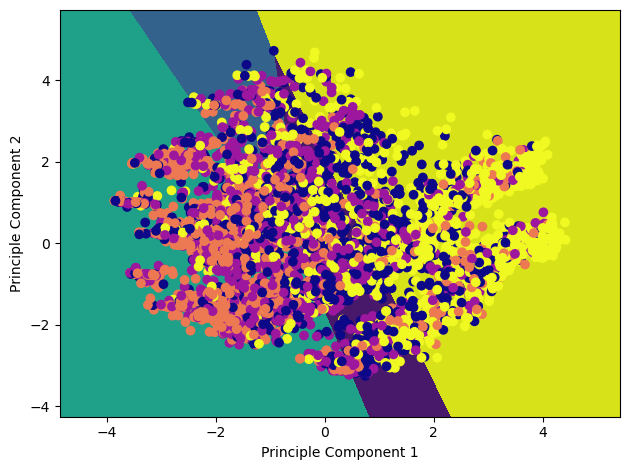

In [61]:
X_2PC = X_tr_99[:, :2]
 #Fit new LogReg on 2 PCs
log_reg_2PC = LogisticRegression().fit(X_2PC, y_tr)
 #Display
disp = DecisionBoundaryDisplay.from_estimator(log_reg_2PC, X_2PC, grid_resolution=len(X_2PC), response_method="predict",
                                              xlabel='Principle Component 1', ylabel='Principle Component 2')
disp.ax_.scatter(X_2PC[:, 0], X_2PC[:, 1], c= y_tr, cmap='plasma')
plt.tight_layout()
plt.show()

Now that we've reduced the dimensionality of the dataset and explored the principal components, we can evaluate the memory savings and how the principal components perform in predicting our four labels.

In [62]:
orig_mem = feats_df.memory_usage().sum()/1024
enc_mem = cust_tr.memory_usage().sum()/1024
scaled_mem = X_tr.memory_usage().sum()/1024
pc_95_mem = pd.DataFrame(X_tr_95).memory_usage().sum()/1024
pc_99_mem = pd.DataFrame(X_tr_99).memory_usage().sum()/1024

print('9 original features memory usage: '+str({}).format(round(orig_mem, 2))+' KB')
print('26 encoded features memory usage: '+str({}).format(round(enc_mem, 2))+' KB')
print('26 scaled features memory usage: '+str({}).format(round(scaled_mem, 2))+' KB')
print('18 Principal Components (95% var) memory usage: '+str({}).format(round(pc_95_mem, 2))+' KB')
print('21 Principal Components (99% var) memory usage: '+str({}).format(round(pc_99_mem, 2))+' KB')

9 original features memory usage: 416.69 KB
26 encoded features memory usage: 703.07 KB
26 scaled features memory usage: 1132.14 KB
18 Principal Components (95% var) memory usage: 783.83 KB
21 Principal Components (99% var) memory usage: 914.45 KB


In [63]:
#Create models + fit principal components
log_reg_95 = LogisticRegression(max_iter=2_500)
log_reg_99 = LogisticRegression(max_iter=2_500)

log_reg_95.fit(X_tr_95, y_tr)
log_reg_99.fit(X_tr_99, y_tr)

#Transform test set into PCA-reduced sets
X_te_99 = pca_99.transform(X_te)
X_te_95 = X_te_99[:, :dim_95]

#Predict with LogReg models
pc_95_score = log_reg_95.score(X_te_95, y_te)
pc_99_score = log_reg_99.score(X_te_99, y_te)

print('Accuracy with 18/26 PC:', pc_95_score)
print('Accuracy with 21/26 PC:', pc_99_score)

Accuracy with 18/26 PC: 0.5129310344827587
Accuracy with 21/26 PC: 0.5280172413793104


In [64]:
#Calculate memory + accuracy changes
delta_mem_95 = pc_95_mem/scaled_mem*100
delta_mem_99 = pc_99_mem/scaled_mem*100

delta_acc_95 = pc_95_score/base_score*100
delta_acc_99 = pc_99_score/base_score*100

#Output in %
print('95% var PC\'s vs scaled features memory proportion: {}'.format(round(delta_mem_95))+'%')
print('99% var PC\'s vs scaled features memory proportion: {}'.format(round(delta_mem_99))+'%')
print('95% var PC\'s vs scaled data LogReg accuracy proportion: {}'.format(round(delta_acc_95))+'%')
print('99% var PC\'s vs scaled data LogReg accuracy proportion: {}'.format(round(delta_acc_99))+'%')

95% var PC's vs scaled features memory proportion: 69%
99% var PC's vs scaled features memory proportion: 81%
95% var PC's vs scaled data LogReg accuracy proportion: 97%
99% var PC's vs scaled data LogReg accuracy proportion: 100%


While all transformations increased the size of the original feature set:
- Applying PCA (at 99% retained variance) to the scaled features reduced dimensionality from 26 to 21 and memory to ~81% of its former size, while retaining the original accuracy
- For PCA with 95% retained variance, 98% of original accuracy and an additional 12% memory size reduction was achieved with only 18 dimensions